In [48]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import ast
import collections
import pickle
import nltk
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
import re
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import mannwhitneyu
from pymystem3 import Mystem

In [49]:
df_train = pd.read_csv("dataset/train_dataset_train_full.csv")
df_test = pd.read_csv("dataset/test_dataset_test_full.csv")

In [50]:
df_train.sample()

,document_id,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,full_text
1707,62679d5c9a7947e6bd965a69IFQgmnEWSEmjDJL3lnbNBg,Valio продаст бизнес в России вместе с правами...,2022-04-26 07:26:06,IFQgmnEWSEmjDJL3lnbNBg,['541953f5cbb20f219c67bf00'],2.869,540d5eafcbb20f2524fc0509,"['542bde7ecbb20f2b668dfd5a', '543bf14fcbb20f2f...",14903,1.044,30.289,Финский концерн Valio объявил о завершении пер...


In [51]:
def time_features(df, name_date):
    """
        Добавляем временные фичи: число, месяц, час, год, номер недели, день недели. 
    """
    df['day_month'] = pd.to_datetime(df[name_date]).dt.strftime("%d").astype(int)
    df['month'] = pd.to_datetime(df[name_date]).dt.strftime("%m").astype(int)
    df['hour'] = pd.to_datetime(df[name_date]).dt.strftime("%H").astype(int)
    df['year'] = pd.to_datetime(df[name_date]).dt.strftime("%y").astype(int)
    df['number_week'] = pd.to_datetime(df[name_date]).dt.strftime("%W").astype(int)
    df['day_week'] = pd.to_datetime(df[name_date]).dt.strftime("%w").astype(int)
    df[name_date] = pd.to_datetime(df[name_date]).dt.date

In [52]:
time_features(df_train, 'publish_date')
time_features(df_test, 'publish_date')

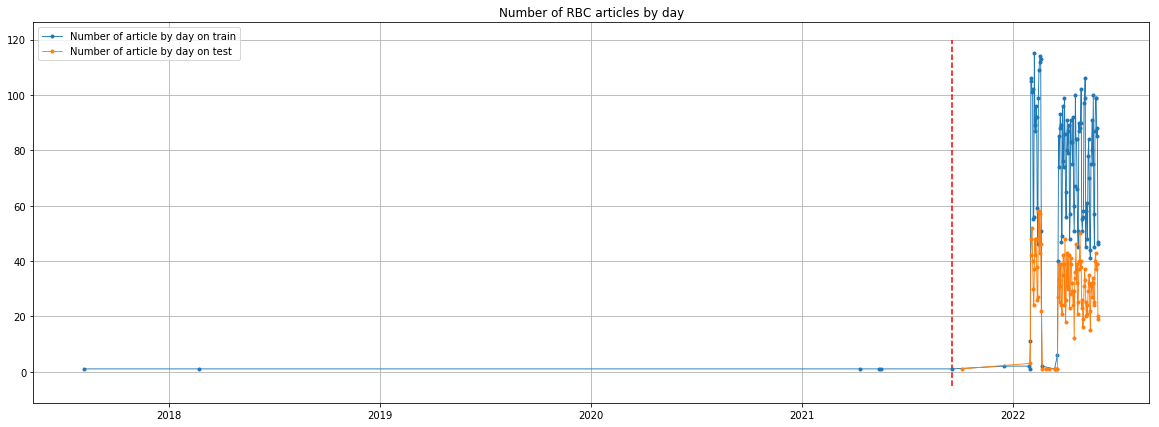

In [53]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(df_train.groupby(['publish_date'])['ctr'].count(),
        marker='.',
        linestyle='-', 
        linewidth=0.9, 
        label='Number of article by day on train'
       )
ax.plot(df_test.groupby(['publish_date'])['ctr'].count(),
        marker='.',
        linestyle='-', 
        linewidth=0.9, 
        label='Number of article by day on test'
       )
ax.vlines(x=datetime.date(2021,9,17),
           ymin=-5, 
           ymax=120, 
           colors='r', 
           linestyles='dashed')
ax.set_title("Number of RBC articles by day")
ax.grid()
ax.legend();

In [54]:
# фильтрация на трейне нерелевантных статей
df_train = df_train[df_train['publish_date'] >= datetime.date(2021,9,17)]

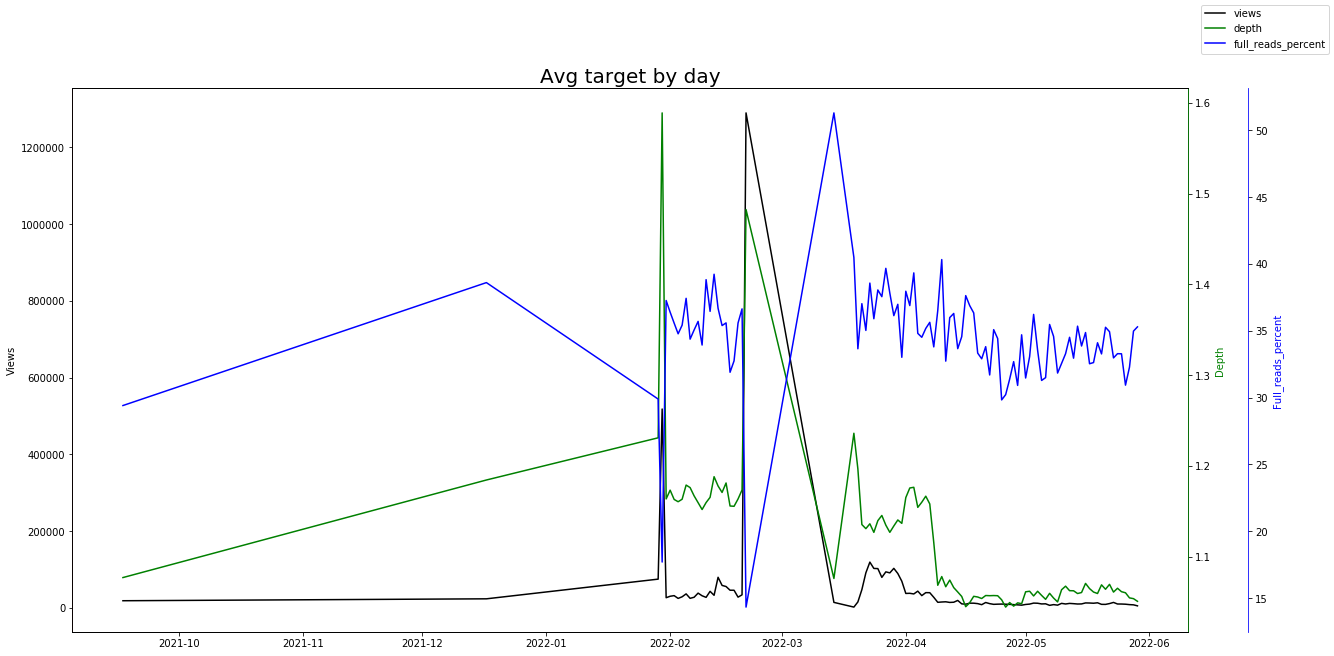

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.spines['left'].set_color('r')
ax1 = ax.twinx()
ax2 = ax.twinx()
ax1.spines['right'].set_color('g')
ax2.spines['right'].set_color('b')
ax2.spines['right'].set_position(('outward', 60))
ax.plot(df_train.groupby(['publish_date'])['views'].mean(), color='black',label='views')
ax.set_ylabel('Views')
ax1.plot(df_train.groupby(['publish_date'])['depth'].mean(),color='g',label='depth')
ax1.set_ylabel('Depth')
ax1.yaxis.label.set_color('green')
ax2.plot(df_train.groupby(['publish_date'])['full_reads_percent'].mean(),color='b',label='full_reads_percent')
ax2.set_ylabel('Full_reads_percent')
ax2.yaxis.label.set_color('blue')
ax.set_title("Avg target by day", fontsize=20)
fig.legend();

In [56]:
def remove_gap(df):
    """
        Удаление гэпа по датам в выборке трейна, 
        Добавляются определные даты соответсвующих дней недели.
    """
    date_add = [datetime.date(2022,3,14), 
                datetime.date(2022,3,21), 
                datetime.date(2022,3,22), 
                datetime.date(2022,3,24)]
    df_temp = df.query(f"publish_date in {date_add}")
    df_temp['publish_date'].replace([
                                     datetime.date(2022,3,20)
                                    ],
                                    datetime.date(2022,3,1), inplace=True)

    df_temp['publish_date'].replace([
                                     datetime.date(2022,3,22)
                                    ],
                                    datetime.date(2022,3,1), inplace=True)

    df_temp['publish_date'].replace([
                                     datetime.date(2022,3,21)
                                    ],
                                    datetime.date(2022,3,1), inplace=True)
    print("add rows in train", len(df_temp))

    return pd.concat([df, df_temp])

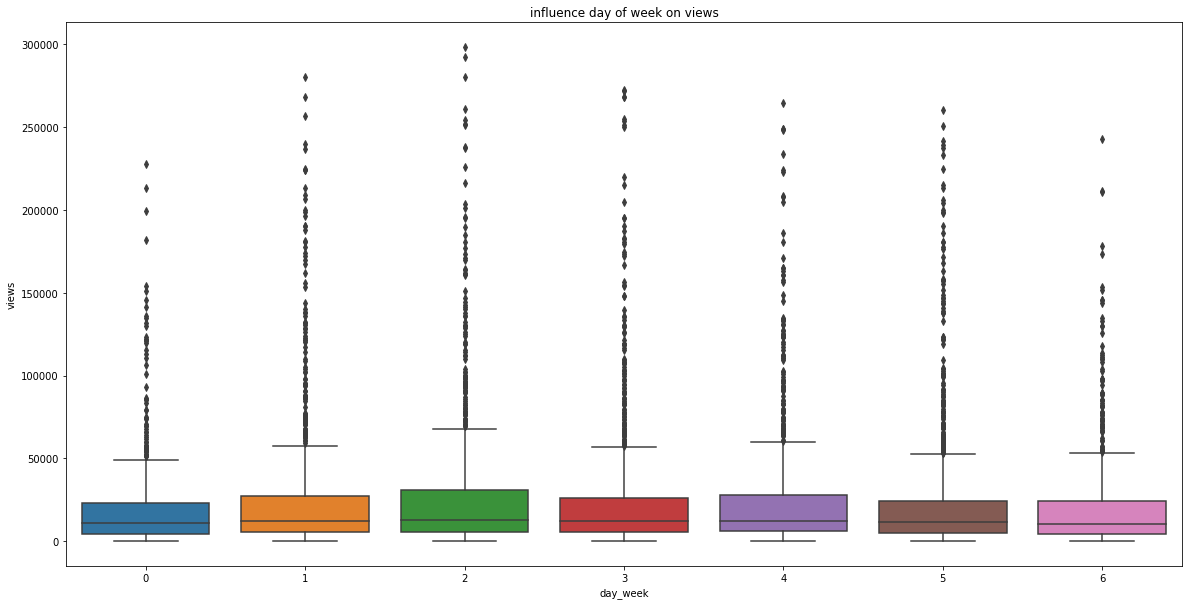

In [57]:
plt.subplots(figsize=(20, 10))
sns.boxplot(x='day_week', y='views', data=df_train.query("views<300000"))
plt.title("influence day of week on views")
plt.show();

In [58]:
# просмотры по пн и ср различаются статзначимо. 
stat, p = mannwhitneyu(df_train[df_train['day_week']==0]['views'], 
                       df_train[df_train['day_week']==2]['views']
                      )
p < 0.01

True

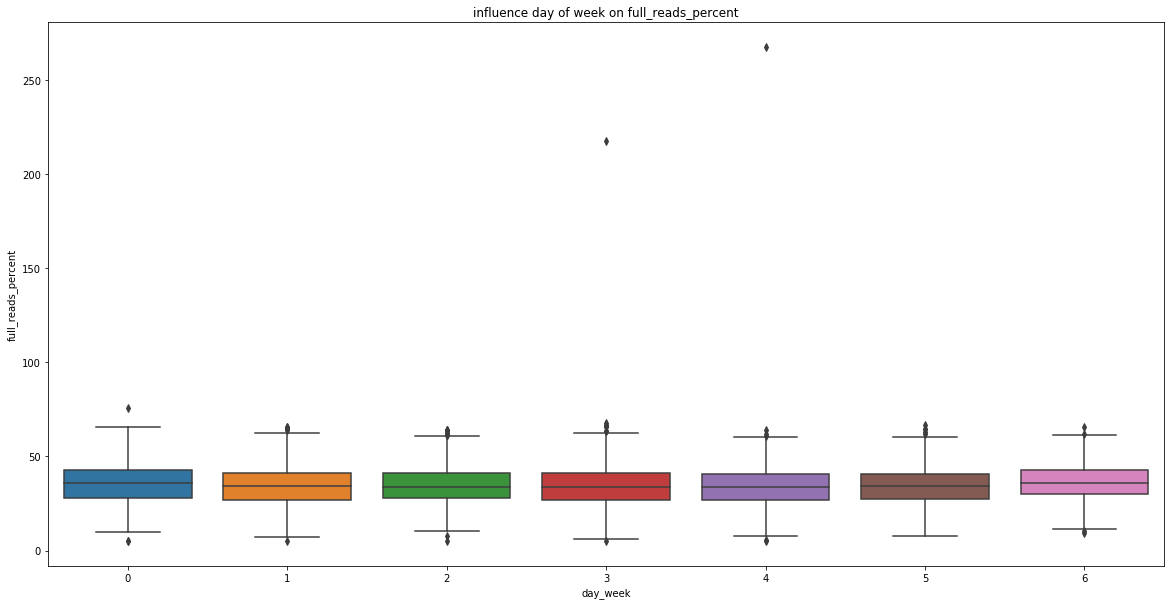

In [59]:
plt.subplots(figsize=(20, 10))
sns.boxplot(x='day_week', y='full_reads_percent', data=df_train)
plt.title("influence day of week on full_reads_percent")
plt.show();

In [60]:
#значение таргета full_reads_percent выше 100 меняем на средние показатели по треййну
df_train['full_reads_percent'] = df_train['full_reads_percent'].apply(lambda x: x if x <= 100 else 
                                                                     df_train['full_reads_percent'].mean())

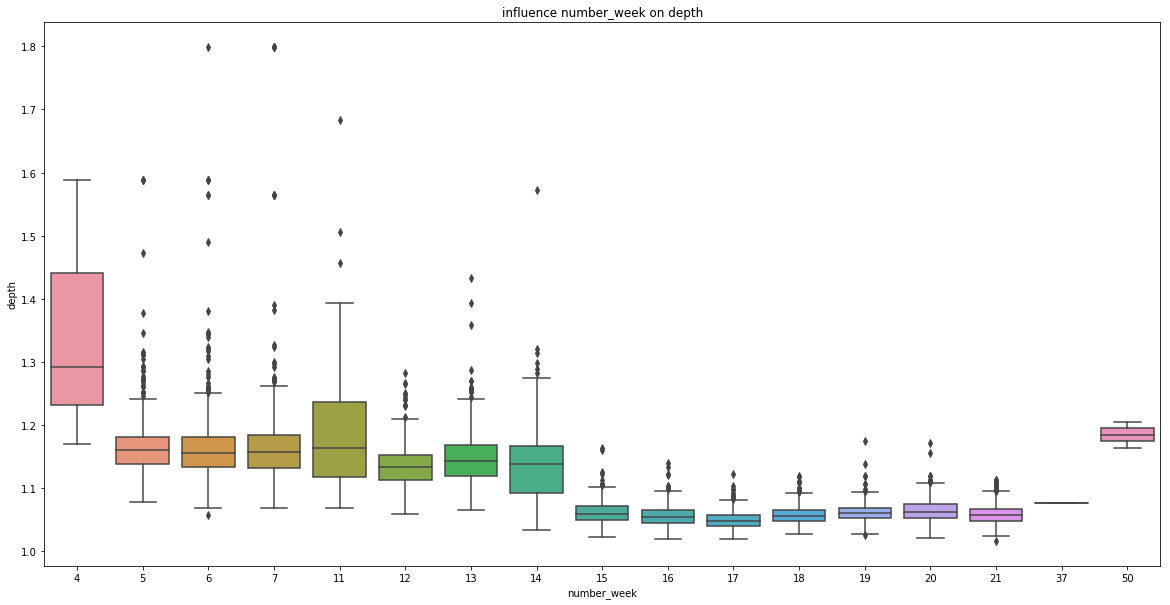

In [61]:
plt.subplots(figsize=(20, 10))
sns.boxplot(x='number_week', y='depth', data=df_train)
plt.title("influence number_week on depth")
plt.show();

Document_id and session

In [62]:
df_train['document_id_1'] = df_train['document_id'].apply(lambda x: x[0:1])
df_test['document_id_1'] = df_test['document_id'].apply(lambda x: x[0:1])

In [63]:
df_train['document_id_2'] = df_train['document_id'].apply(lambda x: x[0:2])
df_test['document_id_2'] = df_test['document_id'].apply(lambda x: x[0:2])

In [64]:
df_train['document_id_3'] = df_train['document_id'].apply(lambda x: x[0:3])
df_test['document_id_3'] = df_test['document_id'].apply(lambda x: x[0:3])

In [65]:
df_train['document_id_4'] = df_train['document_id'].apply(lambda x: x[0:4])
df_test['document_id_4'] = df_test['document_id'].apply(lambda x: x[0:4])

In [66]:
df_train['document_id_5'] = df_train['document_id'].apply(lambda x: x[-1])
df_test['document_id_5'] = df_test['document_id'].apply(lambda x: x[-1])

In [67]:
df_train['document_id_1'].value_counts()

6    6971
5      24
Name: document_id_1, dtype: int64

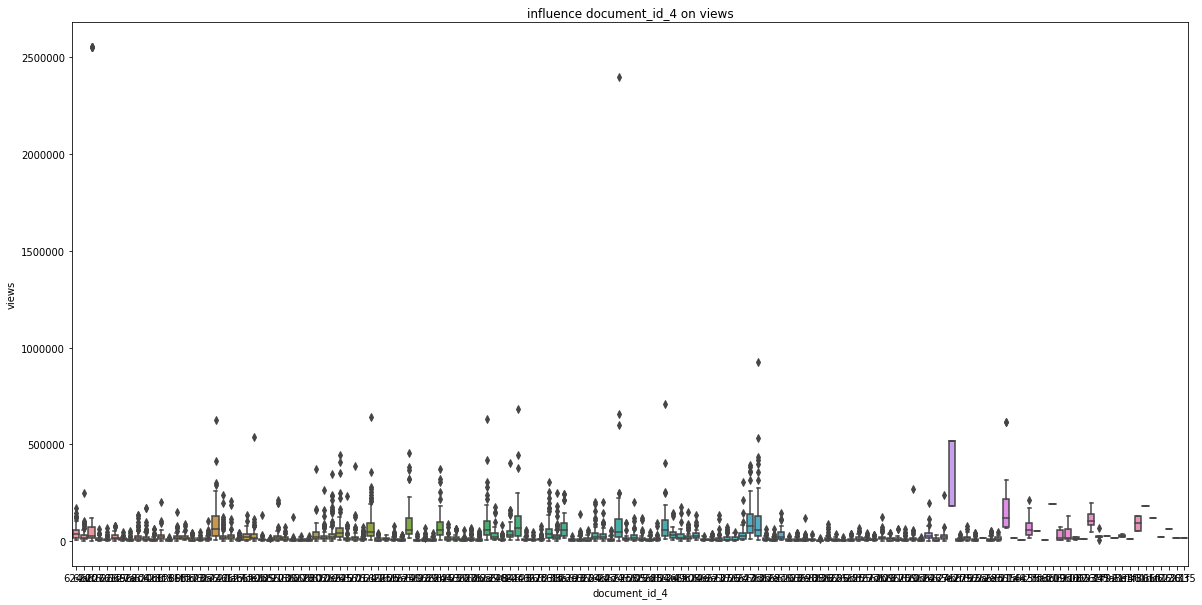

In [68]:
plt.subplots(figsize=(20, 10))
sns.boxplot(x='document_id_4', y='views', data=df_train)
plt.title("influence document_id_4 on views")
plt.show();

In [69]:
'''
plt.subplots(figsize=(20, 10))
sns.boxplot(x='category', y='views', data=df_train.query("views<300000"))
plt.title("influence category on views")
plt.xticks(rotation = 90)
plt.show();
'''

'\nplt.subplots(figsize=(20, 10))\nsns.boxplot(x=\'category\', y=\'views\', data=df_train.query("views<300000"))\nplt.title("influence category on views")\nplt.xticks(rotation = 90)\nplt.show();\n'

In [70]:
freq_categories = collections.Counter(df_train['category'].tolist())
freq_categories.most_common(503)

[('5409f11ce063da9c8b588a12', 3986),
 ('5433e5decbb20f277b20eca9', 1453),
 ('540d5eafcbb20f2524fc0509', 667),
 ('5409f11ce063da9c8b588a13', 338),
 ('540d5ecacbb20f2524fc050a', 283),
 ('5409f11ce063da9c8b588a18', 265),
 ('5e54e2089a7947f63a801742', 1),
 ('552e430f9a79475dd957f8b3', 1),
 ('5e54e22a9a7947f560081ea2', 1)]

In [71]:
# заменим одиночные категории наиболее популярной
garbage_categories = ['5e54e22a9a7947f560081ea2', '552e430f9a79475dd957f8b3', '5e54e2089a7947f63a801742']
df_train.replace(garbage_categories, "5409f11ce063da9c8b588a12", inplace=True)

In [72]:
# к типу объект
df_train['tags'] = df_train['tags'].apply(lambda x: ' '.join(ast.literal_eval(x)))
df_test['tags'] = df_test['tags'].apply(lambda x: ' '.join(ast.literal_eval(x)))

In [73]:
df_train['number_tags'] = df_train['tags'].apply(lambda x: len(x.split()))
df_test['number_tags'] = df_test['tags'].apply(lambda x: len(x.split()))

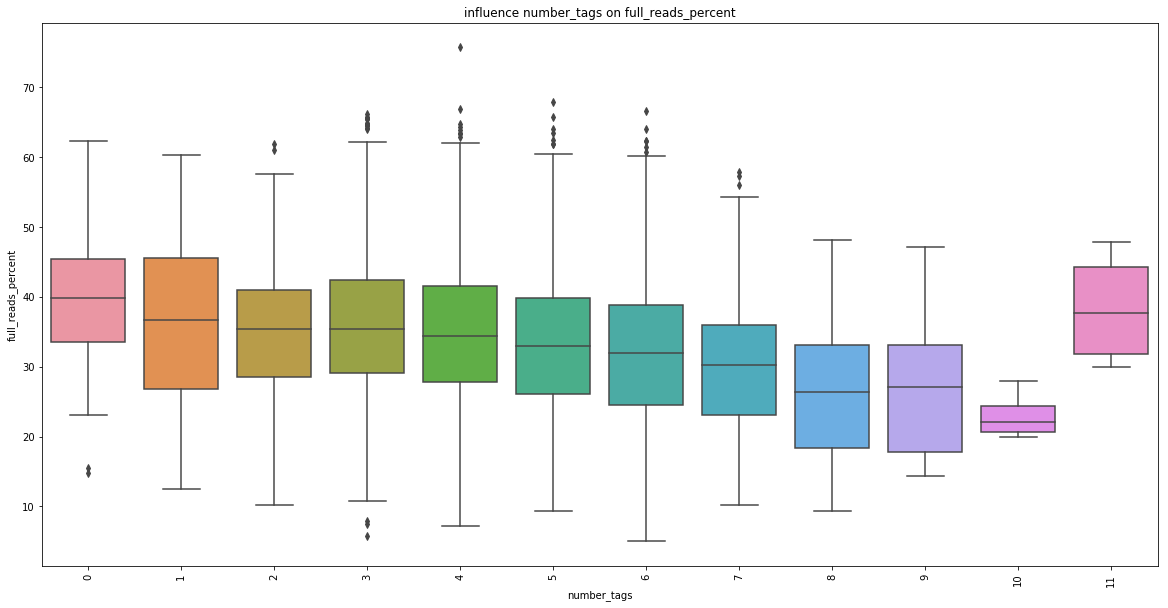

In [74]:
plt.subplots(figsize=(20, 10))
sns.boxplot(x='number_tags', y='full_reads_percent', data=df_train)
plt.title("influence number_tags on full_reads_percent")
plt.xticks(rotation = 90)
plt.show();

In [75]:
all_tags = [tag for tags in df_train['tags'].tolist() for tag in tags.split()]
freq_tag = collections.Counter(all_tags)
freq_tag.most_common(500)

[('5409f15de063daa0f408ada8', 1371),
 ('621a3d0c9a794728d449ae5e', 720),
 ('5409f294e063daa0f408b111', 480),
 ('58abcf539a7947f18bc079eb', 466),
 ('5409f15ee063daa0f408adb0', 457),
 ('5409f140e063daa0f408ad1d', 434),
 ('5577f72f9a7947f6177effbc', 276),
 ('5409f198e063daa0f408ae6b', 236),
 ('5409f196e063daa0f408ae65', 225),
 ('59e769ab9a794784016dbf12', 220),
 ('545caa9ecbb20f366651641e', 201),
 ('5409f309e063daa0f408b1dd', 197),
 ('5409f15be063daa0f408ad93', 194),
 ('5409f200e063daa0f408af68', 181),
 ('5409f1a3e063daa0f408ae98', 180),
 ('5409f191e063daa0f408ae5c', 160),
 ('55110d0e9a79475861c1cbdb', 157),
 ('5409f1afe063daa0f408aeb7', 156),
 ('546e40e7cbb20f1d52dbaa55', 149),
 ('543d3460cbb20f079e577c75', 123),
 ('5e8ec7799a7947848604a99e', 122),
 ('5409f15de063daa0f408ada9', 121),
 ('5409f168e063daa0f408add3', 112),
 ('5409f1a2e063daa0f408ae94', 112),
 ('542d1e28cbb20f862ac2c1f6', 111),
 ('5426a035cbb20f7903d4f89f', 105),
 ('5409f37be063daa0f408b2ae', 105),
 ('5409f336e063daa0f408b236

In [76]:
print('500 популярных тэгов покрывают треть всех указынных тэгов в корпуса (что соответсвует частотности 9):', 
      np.array(freq_tag.most_common(500))[:, 1].astype(int).sum() / len(all_tags)*100)

500 популярных тэгов покрывают треть всех указынных тэгов в корпуса (что соответсвует частотности 9): 64.67319783594093


In [77]:
def signif_tag(tag1, tag2):
    tag_1, tag_2 = [], []
    for index, rows in df_train.iterrows():
        if tag1 in rows['tags'].split():
            tag_1.append(rows['views'])
        elif tag2 in rows['tags'].split():
            tag_2.append(rows['views'])
    stat, p = mannwhitneyu(tag_1, 
                           tag_2
                          )
    return p < 0.01

In [78]:
signif_tag('5409f15de063daa0f408ada8', '5409f15ee063daa0f408adb0')

True

In [79]:
signif_tag('59e769ab9a794784016dbf12', '545caa9ecbb20f366651641e')

False

In [80]:
signif_tag('542580eacbb20f48618cb28b', '5430f451cbb20f73931ecd05')

False

In [81]:
df_train['authors'] = df_train['authors'].apply(lambda x: ' '.join(ast.literal_eval(x)))
df_test['authors'] = df_test['authors'].apply(lambda x: ' '.join(ast.literal_eval(x)))

In [82]:
df_train['number_authors'] = df_train['authors'].apply(lambda x: len(x.split()))
df_test['number_authors'] = df_test['authors'].apply(lambda x: len(x.split()))

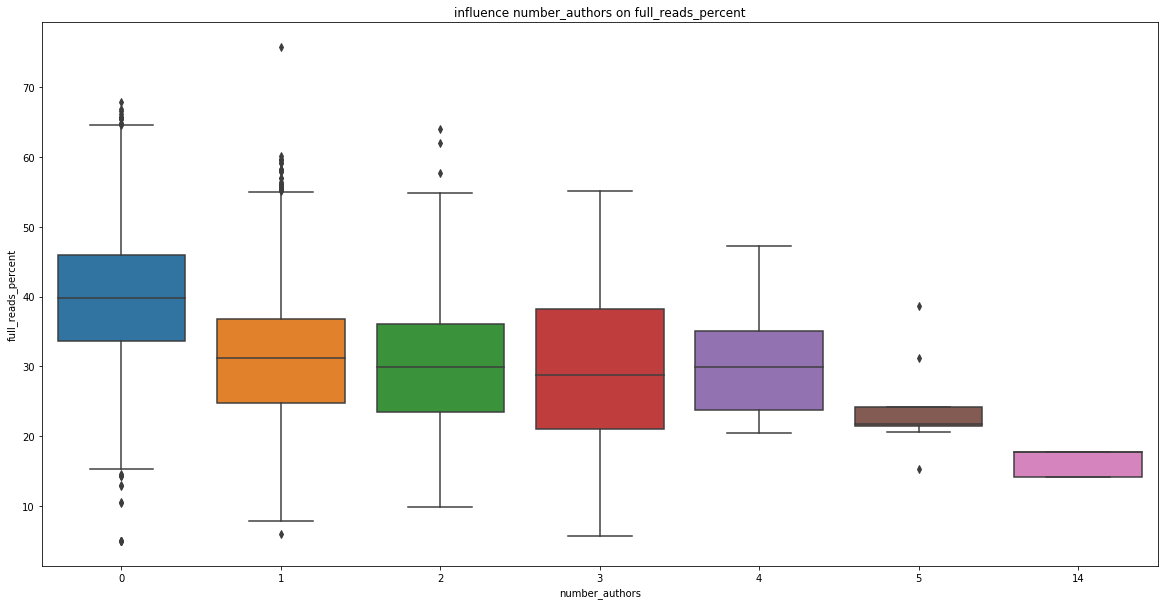

In [83]:
plt.subplots(figsize=(20, 10))
sns.boxplot(x='number_authors', y='full_reads_percent', data=df_train)
plt.title("influence number_authors on full_reads_percent")
plt.show();

In [84]:
all_authors = [author for authors in df_train['authors'].tolist() for author in authors.split()]
freq_authors = collections.Counter(all_authors)
freq_authors.most_common(50)

[('604f2c199a79478ec0029eae', 432),
 ('619226fb9a7947e681606cc3', 396),
 ('60bf2f0f9a79475cc856c5a1', 272),
 ('5a9fa2e39a79470cd086f61a', 251),
 ('5bfd1d039a794755995093f8', 251),
 ('5e1ddee09a7947609de2f69b', 237),
 ('5a8d11a39a7947c5e1550980', 228),
 ('5edf68259a79470758e7ab2d', 214),
 ('6130a7379a79472aeb4546e3', 195),
 ('5b4c70ae9a79472e05ca3037', 174),
 ('57f797ee9a7947a5681d187e', 157),
 ('6206513e9a79476587e1e14e', 137),
 ('60fa94ed9a7947b7152c986a', 126),
 ('61309cc39a7947257ab1d378', 107),
 ('5e4663219a794736af922488', 86),
 ('54244e01cbb20f03076b236d', 77),
 ('5878a2ec9a7947e531faf52c', 74),
 ('61811d649a7947d02fdf5d95', 67),
 ('54254690cbb20fa485b88cc9', 66),
 ('606dbb339a7947bd8e80a947', 66),
 ('54215736cbb20f5cdfa7a8ce', 62),
 ('54195a4fcbb20f219d7fa7dd', 61),
 ('5f106dd79a7947e2d2c14f68', 59),
 ('5d5be3429a79472e44c19a73', 57),
 ('5b8403979a79477107927783', 51),
 ('5bf2cdb19a7947e0aa3f5fa8', 43),
 ('61fcf3d49a794754b3f9e39e', 40),
 ('5f36b3779a794782606d90c9', 40),
 ('59a

In [85]:
print('50 популярных авторов покрывают 93% всех указынных авторов (что соответсвует частотности 20):', 
      np.array(freq_authors.most_common(50))[:, 1].astype(int).sum() / len(all_authors)*100)

50 популярных авторов покрывают 93% всех указынных авторов (что соответсвует частотности 20): 93.16136772645471


In [86]:
df_train['title_original'] = df_train['title']
df_test['title_original'] = df_test['title']

In [87]:
def clean_title(x):
    return x.split('\n')[0]

In [88]:
df_train['title'] = df_train['title'].apply(lambda x: clean_title(x))
df_test['title'] = df_test['title'].apply(lambda x: clean_title(x))

In [89]:
df_train['number_title'] = df_train['title'].apply(lambda x: len(x.split()))
df_test['number_title'] = df_test['title'].apply(lambda x: len(x.split()))

In [90]:
def RemovePunctuation(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    text = [token for token in text.split() if token not in russian_stopwords]
    return ' '.join(text)

In [91]:
df_train['title'] = df_train['title'].apply(lambda x: RemovePunctuation(x))
df_test['title'] = df_test['title'].apply(lambda x: RemovePunctuation(x))

In [92]:
mystem = Mystem()
def mystem_convert(text):
    lemmas = mystem.lemmatize(text) 
    return ''.join(lemmas).strip()

In [93]:
#df_train['title'] = df_train['title'].apply(lambda x: mystem_convert(x))
#df_test['title'] = df_test['title'].apply(lambda x: mystem_convert(x))

In [94]:
all_titles = [title for titles in df_train['title'].tolist() for title in titles.split()]
freq_titles = collections.Counter(all_titles)
for i in freq_titles.most_common(800):
    print(i)

('россии', 925)
('заявил', 473)
('сша', 423)
('украине', 397)
('украины', 326)
('назвал', 266)
('сообщил', 261)
('путин', 213)
('минобороны', 208)
('против', 195)
('нато', 184)
('covid', 182)
('глава', 169)
('мид', 168)
('ес', 165)
('узнал', 164)
('заявили', 158)
('санкций', 142)
('власти', 131)
('москве', 126)
('песков', 123)
('россия', 123)
('российских', 122)
('области', 120)
('днр', 119)
('сообщили', 115)
('путина', 113)
('санкции', 111)
('зеленский', 109)
('призвал', 108)
('украину', 105)
('россию', 104)
('суд', 104)
('планах', 101)
('сообщило', 99)
('тыс', 98)
('газа', 96)
('предложил', 95)
('сообщила', 93)
('оон', 91)
('военных', 88)
('лнр', 87)
('назвали', 85)
('заявила', 84)
('байден', 82)
('москвы', 81)
('россией', 80)
('цб', 78)
('узнала', 77)
('млн', 76)
('россиян', 73)
('млрд', 73)
('кремль', 72)
('газ', 71)
('экс', 70)
('российские', 67)
('19', 66)
('лавров', 66)
('дипломатов', 66)
('2', 66)
('азовстали', 66)
('ск', 66)
('bloomberg', 64)
('1', 64)
('путиным', 62)
('лукаше

In [96]:
print('800 популярных слов покрывают половину всех указынных слов titles в корпусе (что соответсвует частотности 12):', 
      np.array(freq_titles.most_common(800))[:, 1].astype(int).sum() / len(all_titles)*100)

800 популярных слов покрывают половину всех указынных слов titles в корпусе (что соответсвует частотности 12): 48.622031609880075


In [97]:
df_test['full_text_original'] = df_test['full_text']
df_train['full_text_original'] = df_train['full_text']

In [98]:
df_train['number_text'] = df_train['full_text'].apply(lambda x: len(str(x).split()))
df_test['number_text'] = df_test['full_text'].apply(lambda x: len(str(x).split()))

In [99]:
df_train['full_text'] = df_train['full_text'].apply(lambda x: RemovePunctuation(x))
df_test['full_text'] = df_test['full_text'].apply(lambda x: RemovePunctuation(x))

In [100]:
#df_train['full_text'] = df_train['full_text'].apply(lambda x: mystem_convert(x))
#df_test['full_text'] = df_test['full_text'].apply(lambda x: mystem_convert(x))

In [101]:
all_text = [text for texts in df_train['full_text'].tolist() for text in texts.split()]
freq_text = collections.Counter(all_text)
for i in freq_text.most_common(1500):
    print(i)

('россии', 16494)
('также', 9156)
('года', 7506)
('это', 7163)
('сша', 6080)
('заявил', 5892)
('украины', 5871)
('украине', 5514)
('марта', 5415)
('апреля', 4710)
('февраля', 4428)
('рбк', 4426)
('страны', 4301)
('году', 4283)
('словам', 4165)
('президент', 4098)
('российских', 4083)
('которые', 3998)
('сообщил', 3978)
('россия', 3841)
('1', 3811)
('тыс', 3684)
('глава', 3584)
('время', 3472)
('против', 3337)
('сказал', 3298)
('числе', 3258)
('мая', 3105)
('компании', 3091)
('области', 3051)
('ранее', 3029)
('руб', 3029)
('млн', 3021)
('минобороны', 2988)
('безопасности', 2895)
('пресс', 2853)
('2', 2842)
('владимир', 2754)
('5', 2751)
('млрд', 2732)
('путин', 2718)
('российской', 2694)
('данным', 2687)
('президента', 2624)
('военной', 2597)
('власти', 2586)
('операции', 2511)
('сообщили', 2481)
('начала', 2428)
('нато', 2386)
('2021', 2363)
('ес', 2338)
('стран', 2319)
('который', 2291)
('днр', 2271)
('лнр', 2269)
('3', 2237)
('российские', 2228)
('российского', 2192)
('однако', 2144)

In [103]:
print('1500 популярных слов покрывают 49% текста full_text (что соответсвует частотности 187):', 
      np.array(freq_text.most_common(1500))[:, 1].astype(int).sum() / len(all_text)*100)

1500 популярных слов покрывают 49% текста full_text (что соответсвует частотности 214): 49.70940170940171


In [104]:
df_currency = pd.read_csv("utils/currency.csv")
df_currency['index'] = pd.to_datetime(df_currency['index'])

In [105]:
df_train['publish_date'] = pd.to_datetime(df_train['publish_date'])
df_train = pd.merge(df_train, df_currency, how='left', left_on='publish_date', right_on='index') 

In [106]:
df_test['publish_date'] = pd.to_datetime(df_test['publish_date'])
df_test = pd.merge(df_test, df_currency, how='left', left_on='publish_date', right_on='index') 

In [107]:
df_train[['views','depth','full_reads_percent','ctr', 'number_title', 'number_text', 'number_tags', 'number_authors', 'curs']].corr()

,views,depth,full_reads_percent,ctr,number_title,number_text,number_tags,number_authors,curs
views,1.000000,0.387388,-0.112148,0.253080,-0.019777,0.257346,0.046709,0.152169,0.217643
depth,0.387388,1.000000,0.204032,-0.100671,0.004765,0.130539,-0.037126,0.107511,0.387113
full_reads_percent,-0.112148,0.204032,1.000000,-0.306604,0.026427,-0.197685,-0.126205,-0.348205,0.114161
ctr,0.253080,-0.100671,-0.306604,1.000000,-0.059200,0.090303,0.039364,0.263389,0.034957
number_title,-0.019777,0.004765,0.026427,-0.059200,1.000000,-0.024771,0.109957,-0.043374,-0.020531
number_text,0.257346,0.130539,-0.197685,0.090303,-0.024771,1.000000,0.089801,0.067116,0.008939
number_tags,0.046709,-0.037126,-0.126205,0.039364,0.109957,0.089801,1.000000,0.019891,-0.039815
number_authors,0.152169,0.107511,-0.348205,0.263389,-0.043374,0.067116,0.019891,1.000000,0.073844
curs,0.217643,0.387113,0.114161,0.034957,-0.020531,0.008939,-0.039815,0.073844,1.000000


In [64]:
skf = StratifiedKFold(n_splits=4, shuffle=True)
fold = 0
for train_index, test_index in skf.split(df_train.index, df_train.document_id_1):
    with open(f'utils/splits/test_fold_{fold}.pkl', 'wb') as handle:
        pickle.dump(test_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'utils/splits/train_fold_{fold}.pkl', 'wb') as handle:
        pickle.dump(train_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    fold+=1

In [108]:
df_train.to_parquet('dataset/train_dataset_train_full_proc.parquet')

In [109]:
df_test.to_parquet('dataset/test_dataset_test_full_proc.parquet')